# Load data

In [1]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from tqdm.notebook import tqdm
from ipywidgets import interact, Dropdown, IntSlider, DatePicker
def horizon(x, M, H):
    number_of_samples = len(x) - H - M
    future = np.zeros((number_of_samples, H))
    c = 0
    for i in range(M, len(x) - H):
        future_slice = x[i:i + H]
        future[c] = future_slice
        c += 1
    return future

def process_single_node_data_2018(G, verbose=False):
    df = pd.read_csv('single_node_data.csv', index_col=0, parse_dates=True)
    df[df.columns] = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float64')
    df = df[~df.index.duplicated(keep='first')]
    df['load[MW]'] = df['load[MW]'].mask(df['load[MW]'] < 100).interpolate(limit_direction='both').ffill().bfill()
    df.index += pd.Timedelta(hours=8)
    df = df.loc["2018-01-01 00:00":"2018-12-31 23:00"]

    l = df['load[MW]'].to_numpy() / 1000
    s = df['pv[MW]'].to_numpy() / 1000
    w = df['wind[MW]'].to_numpy() / 1000
    R = w + s
    netload = l - (R + G)

    infeasible_indices = np.where(netload > 0)[0]
    shortfall = np.maximum(l - (R + G), 0)
    if verbose:
        print(f"percentage of shortfall times = {len(infeasible_indices) / len(l) * 100:.2f} %")
        print(f"average load = {np.mean(l):.2f} GW")
        print(f"average renewable generation = {np.mean(R):.2f} GW")
        print(f"average shortfall = {np.mean(shortfall):.2f} GW")
        print(f"maximum fossil generation = {np.max(G):.2f} GW")
    return l, R, shortfall

G = 1.0
M = 0
l, R, shortfall = process_single_node_data_2018(G, True)
hor_l_1 = horizon(l, M, 1)
hor_R_1 = horizon(R, M, 1)
hor_l_24 = horizon(l, M, 24)
hor_R_24 = horizon(R, M, 24)
hor_l_72 = horizon(l, M, 72)
hor_R_72 = horizon(R, M, 72)

percentage of shortfall times = 16.82 %
average load = 0.97 GW
average renewable generation = 0.71 GW
average shortfall = 0.02 GW
maximum fossil generation = 1.00 GW


# Constants dictionary

In [2]:
constants = {
    'hor_l': None,
    'hor_R': None,
    'G': G,
    'C_max': 0.33,
    'cons_alpha': 1.25,
    'cons_beta': 0.5,
    'cons_lambda': 20.0,
    'cons_gamma': 5.0,
    'cons_mu': None,
    'cons_frac': None,
    'cons_Q': None,
    'H': None,
    'M': M,
    'num_samples': None,
    'number_of_Qs': 6,
    'Qs': np.array([0.0, 2.0, 4.0, 8.0, 16.0, 32.0]),
    'number_of_mus': 5,
    'mus': np.array([0.0, 0.1, 1.0, 10.0, 100.0]),
    'number_of_fracs': 4,
    'fracs': np.array([0.25, 0.5, 0.75, 1.0]),
    }

# Experiment

In [3]:
# --------------------------------------------PRESCIENT------------------------------------------------
def one_shot(l, R, G):
    T = R.shape[0]
    param_Q = cp.Parameter(nonneg=True, name='Q')
    param_alpha = cp.Parameter(nonneg=True, name='alpha')
    param_beta = cp.Parameter(nonneg=True, name='beta')
    param_gamma = cp.Parameter(nonneg=True, name='gamma')
    param_lambda = cp.Parameter(nonneg=True, name='lambda')
    B = cp.Variable(nonneg=True, name='B')
    b = cp.Variable(T, name='b')
    q = cp.Variable(T+1, nonneg=True, name='q')
    r = cp.Variable(T, nonneg=True, name='r')
    u = cp.Variable(T, nonneg=True, name='u')
    s = cp.Variable(T, nonneg=True, name='s')
    c = cp.Variable(T, nonneg=True, name='c')
    constraints = [
        c == R - r,
        r <= R,
        q <= param_Q,
        u <= G,
        cp.abs(b) <= B,
        cp.diff(q) == -b,
        s <= l,
        b + r + u == l - s,
        B == 0.33*param_Q,
        q[0] == 1.0*param_Q,
    ]
    objective = 1/T*(param_gamma*cp.sum(c)+param_lambda*cp.sum(s)+param_alpha*cp.sum(u)+param_beta*cp.sum_squares(u))
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem

def retrieve(problem):
    q = problem.var_dict['q'].value
    b = problem.var_dict['b'].value
    u = problem.var_dict['u'].value
    s = problem.var_dict['s'].value
    c = problem.var_dict['c'].value
    r = problem.var_dict['r'].value
    B = problem.var_dict['B'].value
    return q, b, u, s, c, r, B

def prescient_sweep_Q(l, R, constants):
    Qs = constants['Qs']
    G = constants['G']
    storage = np.zeros((Qs.shape[0], l.shape[0]+1)) #q
    discharge = np.zeros((Qs.shape[0], l.shape[0])) #b
    fossil = np.zeros((Qs.shape[0], l.shape[0])) #u
    slack = np.zeros((Qs.shape[0], l.shape[0])) #s
    curtailment = np.zeros((Qs.shape[0], l.shape[0])) #c
    renewable = np.zeros((Qs.shape[0], l.shape[0])) #r
    max_discharge = np.zeros((Qs.shape[0],)) #B
    problem = one_shot(l, R, G)
    for i,Q in enumerate(Qs):
        print(f"Q = {Q:.2f}")
        problem.param_dict['Q'].value = Q
        problem.param_dict['alpha'].value = constants['cons_alpha']
        problem.param_dict['beta'].value = constants['cons_beta']
        problem.param_dict['gamma'].value = constants['cons_gamma']
        problem.param_dict['lambda'].value = constants['cons_lambda']
        problem.solve(solver=cp.CLARABEL, verbose=False)
        if problem.status == cp.INFEASIBLE:
            raise ValueError(f"Problem infeasible for Q = {Q:.2f}")
        elif problem.status == cp.UNBOUNDED:
            raise ValueError(f"Problem unbounded for Q = {Q:.2f}")
        q, b, u, s, c, r, B = retrieve(problem)
        storage[i] = q
        discharge[i] = b
        fossil[i] = u
        slack[i] = s
        curtailment[i] = c
        renewable[i] = r
        max_discharge[i] = B
    return storage[:,1:], discharge, fossil, slack, curtailment, renewable, max_discharge

# --------------------------------------------MPC------------------------------------------------

def mpc(H):
    # -------------------PARAMETERS-------------------
    l = cp.Parameter(H, nonneg = True, name = 'l')
    R = cp.Parameter(H, nonneg = True, name = 'R')
    G = cp.Parameter(nonneg = True, name = 'G')
    Q = cp.Parameter(nonneg = True, name = 'Q')
    B = cp.Parameter(nonneg = True, name = 'B')
    q_t_1 = cp.Parameter(nonneg = True, name = 'q_t_1')
    alpha = cp.Parameter(nonneg = True, name = 'alpha')
    beta = cp.Parameter(nonneg = True, name = 'beta')
    lambda_ = cp.Parameter(nonneg = True, name = 'lambda')
    gamma = cp.Parameter(nonneg = True, name = 'gamma')
    mu = cp.Parameter(nonneg = True, name = 'mu')
    Q_target = cp.Parameter(nonneg = True, name = 'Q_target')
    # -------------------VARIABLES-------------------
    q = cp.Variable(H + 1, nonneg = True, name = 'q')
    b = cp.Variable(H, name = 'b')
    u = cp.Variable(H, nonneg = True, name = 'u')
    s = cp.Variable(H, nonneg = True, name = 's')
    c = cp.Variable(H, nonneg = True, name = 'c')
    r = cp.Variable(H, nonneg = True, name = 'r')
    delta_q_t = cp.Variable(name = 'delta_q_t')
    
    objective = 1/H*(alpha*cp.sum(u) + beta*cp.sum_squares(u) + lambda_*cp.sum(s) + gamma*cp.sum(c))+ mu*cp.sum_squares(delta_q_t)
    constraints = [r + b + u + s == l,
                   cp.diff(q) == -b,
                   cp.abs(b) <= B,
                   q <= Q,
                   u <= G,
                   r <= R,
                   c == R - r,
                   s <= l,
                   q[0] == q_t_1,
                   delta_q_t == Q_target - q[-1]]
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem

def mpc_set_param(problem, l, R, Q, B, q_t_1, Q_target, constants):
    problem.param_dict['l'].value = l
    problem.param_dict['R'].value = R
    problem.param_dict['G'].value = constants['G']
    problem.param_dict['Q'].value = Q
    problem.param_dict['B'].value = B
    problem.param_dict['q_t_1'].value = q_t_1
    problem.param_dict['Q_target'].value = Q_target
    problem.param_dict['alpha'].value = constants['cons_alpha']
    problem.param_dict['beta'].value = constants['cons_beta']
    problem.param_dict['lambda'].value = constants['cons_lambda']
    problem.param_dict['gamma'].value = constants['cons_gamma']
    problem.param_dict['mu'].value = constants['cons_mu']
    return problem

def mpc_ret_var(problem):
    q = problem.var_dict['q'].value
    b = problem.var_dict['b'].value
    u = problem.var_dict['u'].value
    s = problem.var_dict['s'].value
    c = problem.var_dict['c'].value
    r = problem.var_dict['r'].value
    delta_q_t = problem.var_dict['delta_q_t'].value
    return q, b, u, s, c, r, delta_q_t

def mpc_roll(constants):
    l = constants['hor_l']
    R = constants['hor_R']
    #------------------------------------------------------------------------------------------------------
    q_star = np.zeros((constants['num_samples'],))
    b_star = np.zeros((constants['num_samples'],))
    u_star = np.zeros((constants['num_samples'],))
    s_star = np.zeros((constants['num_samples'],))
    c_star = np.zeros((constants['num_samples'],))
    r_star = np.zeros((constants['num_samples'],))
    delta_q_t_star = np.zeros((constants['num_samples'],))
    q_t_1_star = constants['cons_Q']
    # -------------------------------------------LOOP------------------------------------------------------
    prob_mpc = mpc(constants['H'])
    for t in range(constants['num_samples']):
        #------------------------------------------------------------------------------------------------------
        Q = constants['cons_Q']
        B = constants['C_max']*Q
        Q_target = constants['cons_frac']*Q
        q_t_1 = q_t_1_star
        #------------------------------------------------------------------------------------------------------
        prob_mpc = mpc_set_param(prob_mpc, l[t][:constants['H']], R[t][:constants['H']], Q, B, q_t_1, Q_target, constants)
        prob_mpc.solve(solver=cp.CLARABEL, verbose=False, warm_start=True)
        if prob_mpc.status == cp.INFEASIBLE:
            raise ValueError(f"MPC problem infeasible at timestep {t}, status: {prob_mpc.status}")
        elif prob_mpc.status == cp.UNBOUNDED:
            raise ValueError(f"MPC problem unbounded at timestep {t}, status: {prob_mpc.status}")
        q_H, b_H, u_H, s_H, c_H, r_H, delta_q_t = mpc_ret_var(prob_mpc)
        q_star[t] = q_H[1]
        b_star[t] = b_H[0]
        u_star[t] = u_H[0]
        s_star[t] = s_H[0]
        c_star[t] = c_H[0]
        r_star[t] = r_H[0]
        delta_q_t_star[t] = delta_q_t
        #------------------------------------------------------------------------------------------------------
        q_t_1_star = q_H[1]
    return q_star, b_star, u_star, s_star, c_star, r_star, delta_q_t_star

def mpc_full_sweep(constants):
    Qs = constants['Qs']
    fracs = constants['fracs']
    mus = constants['mus']
    num_Qs = constants['number_of_Qs']
    num_fracs = constants['number_of_fracs']
    num_mus = constants['number_of_mus']
    num_samples = constants['num_samples']

    storage = np.zeros((num_Qs, num_fracs, num_mus, num_samples))
    discharge = np.zeros((num_Qs, num_fracs, num_mus, num_samples))
    fossil = np.zeros((num_Qs, num_fracs, num_mus, num_samples))
    slack = np.zeros((num_Qs, num_fracs, num_mus, num_samples))
    curtailment = np.zeros((num_Qs, num_fracs, num_mus, num_samples))
    renewable = np.zeros((num_Qs, num_fracs, num_mus, num_samples))
    delta_q_t = np.zeros((num_Qs, num_fracs, num_mus, num_samples))

    for i, Q in enumerate(tqdm(Qs, desc="Sweeping Qs")):
        constants['cons_Q'] = Q
        for j, frac in enumerate(tqdm(fracs, leave=False, desc=f"Q={Q:.2f}")):
            constants['cons_frac'] = frac
            for k, mu in enumerate(tqdm(mus, leave=False, desc=f"frac={frac:.2f}")):
                constants['cons_mu'] = mu
                q, b, u, s, c, r, delta_q = mpc_roll(constants)
                storage[i, j, k] = q
                discharge[i, j, k] = b
                fossil[i, j, k] = u
                slack[i, j, k] = s
                curtailment[i, j, k] = c
                renewable[i, j, k] = r
                delta_q_t[i, j, k] = delta_q

    return storage, discharge, fossil, slack, curtailment, renewable, delta_q_t

def calculate_costs_mpc_sweep(constants, u, s, c):
    alpha = constants['cons_alpha']
    beta = constants['cons_beta']
    lamb = constants['cons_lambda']
    gamma = constants['cons_gamma']

    # Elementwise cost arrays
    fossil_costs = alpha * u + beta * np.square(u)
    slack_costs = lamb * s
    curtailment_costs = gamma * c
    total_costs = fossil_costs + slack_costs + curtailment_costs

    return fossil_costs, slack_costs, curtailment_costs, total_costs

def find_best_mpc_combination(constants, total_costs):
    avg_costs = np.mean(total_costs, axis=-1)  # shape (Q, frac, mu)
    num_Qs = avg_costs.shape[0]

    best_Q_mpc_X = []
    best_frac_mpc_X = []
    best_mu_mpc_X = []
    best_cost_mpc_X = []
    best_index_mpc_X = []

    for i in range(num_Qs):
        j, k = np.unravel_index(np.argmin(avg_costs[i]), avg_costs[i].shape)
        best_Q_mpc_X.append(constants['Qs'][i])
        best_frac_mpc_X.append(constants['fracs'][j])
        best_mu_mpc_X.append(constants['mus'][k])
        best_cost_mpc_X.append(avg_costs[i, j, k])
        best_index_mpc_X.append((i, j, k))

    return best_Q_mpc_X, best_frac_mpc_X, best_mu_mpc_X, best_cost_mpc_X, best_index_mpc_X

def print_best_combinations(constants, best_Q, best_frac, best_mu, best_cost):
    print("Best (frac, mu) combinations for each Q:")
    print("-" * 50)
    for i in range(len(best_Q)):
        print(f"Q = {best_Q[i]:>5.2f} → best frac = {best_frac[i]:>4.2f}, best mu = {best_mu[i]:>5.2f}, avg cost = {best_cost[i]:.4f}")

def plot_total_cost_heatmap(constants, avg_total_costs, Q_index):
    fracs = constants['fracs']
    mus = constants['mus']
    Q = constants['Qs'][Q_index]

    data = avg_total_costs[Q_index]  # shape: (frac, mu)

    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(data, cmap='viridis', aspect='auto')

    ax.set_title(f'Avg Total Cost (Q = {Q:.2f})')
    ax.set_xlabel('mu')
    ax.set_ylabel('frac')

    ax.set_xticks(np.arange(len(mus)))
    ax.set_yticks(np.arange(len(fracs)))
    ax.set_xticklabels([f'{m:.2f}' for m in mus])
    ax.set_yticklabels([f'{f:.2f}' for f in fracs])

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Avg Total Cost')

    plt.tight_layout()
    plt.show()

# Prescient

In [4]:
q_pre, b_pre, u_pre, s_pre, c_pre, r_pre, B_pre = prescient_sweep_Q(l, R, constants)

Q = 0.00
Q = 2.00
Q = 4.00
Q = 8.00
Q = 16.00
Q = 32.00


# MPC - 1

In [5]:
H = hor_l_1.shape[1]
E = hor_l_1.shape[0]
constants['hor_l'] = hor_l_1
constants['hor_R'] = hor_R_1
constants['num_samples'] = E
constants['H'] = H
q_mpc_1, b_mpc_1, u_mpc_1, s_mpc_1, c_mpc_1, r_mpc_1, delta_q_t_mpc_1 = mpc_full_sweep(constants)
fossil_costs_mpc_1, slack_costs_mpc_1, curtailment_costs_mpc_1, total_costs_mpc_1 = calculate_costs_mpc_sweep(constants, u_mpc_1, s_mpc_1, c_mpc_1)
best_Q_mpc_1, best_frac_mpc_1, best_mu_mpc_1, best_cost_mpc_1, best_index_mpc_1 = find_best_mpc_combination(constants, total_costs_mpc_1)
print_best_combinations(constants, best_Q_mpc_1, best_frac_mpc_1, best_mu_mpc_1, best_cost_mpc_1)

Sweeping Qs:   0%|          | 0/6 [00:00<?, ?it/s]

Q=0.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=2.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=4.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=8.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=16.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=32.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/giray98/load/lib/python3.12/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Best (frac, mu) combinations for each Q:
--------------------------------------------------
Q =  0.00 → best frac = 0.25, best mu =  1.00, avg cost = 2.6023
Q =  2.00 → best frac = 0.25, best mu =  0.00, avg cost = 2.0456
Q =  4.00 → best frac = 0.25, best mu =  0.10, avg cost = 1.7067
Q =  8.00 → best frac = 1.00, best mu =  0.10, avg cost = 1.2680
Q = 16.00 → best frac = 0.75, best mu =  0.10, avg cost = 0.9131
Q = 32.00 → best frac = 0.50, best mu =  0.10, avg cost = 0.7671


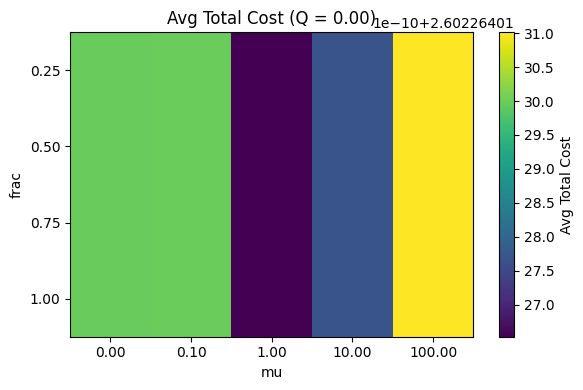

In [6]:
avg_total_costs_mpc_1 = np.mean(total_costs_mpc_1, axis=-1)
plot_total_cost_heatmap(constants, avg_total_costs_mpc_1, Q_index=0)

# MPC - 24

In [7]:
H = hor_l_24.shape[1]
E = hor_l_24.shape[0]
constants['hor_l'] = hor_l_24
constants['hor_R'] = hor_R_24
constants['num_samples'] = E
constants['H'] = H
q_mpc_24, b_mpc_24, u_mpc_24, s_mpc_24, c_mpc_24, r_mpc_24, delta_q_t_mpc_24 = mpc_full_sweep(constants)
fossil_costs_mpc_24, slack_costs_mpc_24, curtailment_costs_mpc_24, total_costs_mpc_24 = calculate_costs_mpc_sweep(constants, u_mpc_24, s_mpc_24, c_mpc_24)
best_Q_mpc_24, best_frac_mpc_24, best_mu_mpc_24, best_cost_mpc_24, best_index_mpc_24 = find_best_mpc_combination(constants, total_costs_mpc_24)
print_best_combinations(constants, best_Q_mpc_24, best_frac_mpc_24, best_mu_mpc_24, best_cost_mpc_24)

Sweeping Qs:   0%|          | 0/6 [00:00<?, ?it/s]

Q=0.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=2.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=4.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=8.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=16.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=32.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Best (frac, mu) combinations for each Q:
--------------------------------------------------
Q =  0.00 → best frac = 0.25, best mu =  0.00, avg cost = 2.5960
Q =  2.00 → best frac = 1.00, best mu =  0.10, avg cost = 1.8169
Q =  4.00 → best frac = 0.75, best mu =  0.10, avg cost = 1.4592
Q =  8.00 → best frac = 0.25, best mu =  0.10, avg cost = 1.0270
Q = 16.00 → best frac = 0.75, best mu =  0.00, avg cost = 0.8164
Q = 32.00 → best frac = 0.25, best mu =  0.00, avg cost = 0.7140


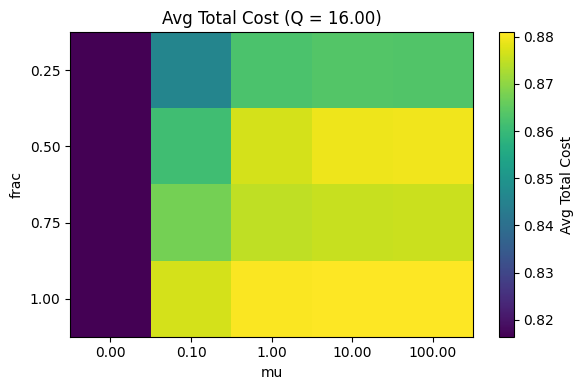

In [8]:
avg_total_costs_mpc_24 = np.mean(total_costs_mpc_24, axis=-1)
plot_total_cost_heatmap(constants, avg_total_costs_mpc_24, Q_index=4)

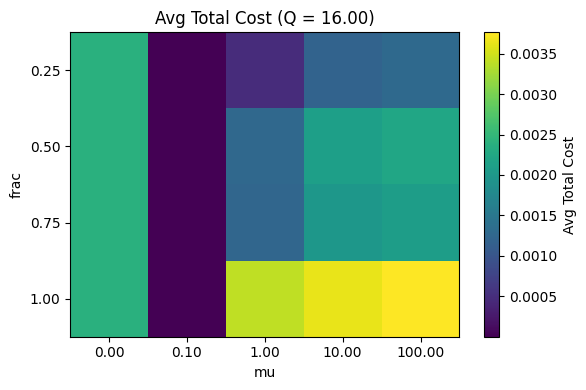

In [9]:
avg_slack_costs_mpc_24 = np.mean(slack_costs_mpc_24, axis=-1)
plot_total_cost_heatmap(constants, avg_slack_costs_mpc_24, Q_index=4)

# MPC - 72

In [10]:
H = hor_l_72.shape[1]
E = hor_l_72.shape[0]
constants['hor_l'] = hor_l_72
constants['hor_R'] = hor_R_72
constants['num_samples'] = E
constants['H'] = H
q_mpc_72, b_mpc_72, u_mpc_72, s_mpc_72, c_mpc_72, r_mpc_72, delta_q_t_mpc_72 = mpc_full_sweep(constants)
fossil_costs_mpc_72, slack_costs_mpc_72, curtailment_costs_mpc_72, total_costs_mpc_72 = calculate_costs_mpc_sweep(constants, u_mpc_72, s_mpc_72, c_mpc_72)
best_Q_mpc_72, best_frac_mpc_72, best_mu_mpc_72, best_cost_mpc_72, best_index_mpc_72 = find_best_mpc_combination(constants, total_costs_mpc_72)
print_best_combinations(constants, best_Q_mpc_72, best_frac_mpc_72, best_mu_mpc_72, best_cost_mpc_72)

Sweeping Qs:   0%|          | 0/6 [00:00<?, ?it/s]

Q=0.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=2.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=4.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=8.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=16.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Q=32.00:   0%|          | 0/4 [00:00<?, ?it/s]

frac=0.25:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.50:   0%|          | 0/5 [00:00<?, ?it/s]

frac=0.75:   0%|          | 0/5 [00:00<?, ?it/s]

frac=1.00:   0%|          | 0/5 [00:00<?, ?it/s]

Best (frac, mu) combinations for each Q:
--------------------------------------------------
Q =  0.00 → best frac = 0.25, best mu =  1.00, avg cost = 2.6023
Q =  2.00 → best frac = 0.50, best mu = 10.00, avg cost = 1.8206
Q =  4.00 → best frac = 0.25, best mu =  0.10, avg cost = 1.4610
Q =  8.00 → best frac = 0.50, best mu =  0.10, avg cost = 1.0261
Q = 16.00 → best frac = 0.25, best mu =  0.10, avg cost = 0.8099
Q = 32.00 → best frac = 1.00, best mu =  0.00, avg cost = 0.7081


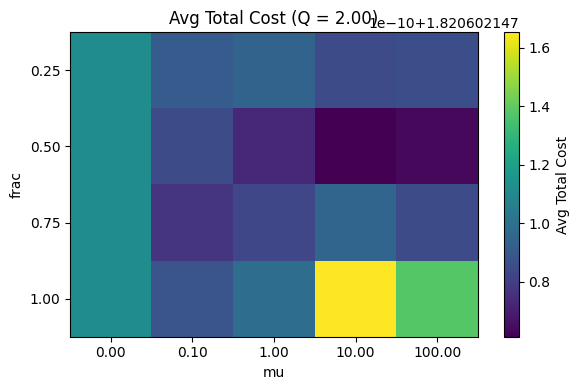

In [11]:
avg_total_costs_mpc_72 = np.mean(total_costs_mpc_72, axis=-1)
plot_total_cost_heatmap(constants, avg_total_costs_mpc_72, Q_index=1)

# Analysis

In [12]:
def calculate_all_metrics(q, b, u, s, c, r, constants):
    num_rows = q.shape[0]
    metrics_list = []

    for i in range(num_rows):
        q_i, b_i, u_i, s_i, c_i, r_i = q[i], b[i], u[i], s[i], c[i], r[i]

        fossil_cost_i = constants['cons_alpha'] * u_i + constants['cons_beta'] * np.square(u_i)
        shortfall_cost_i = constants['cons_lambda'] * s_i
        curtailment_cost_i = constants['cons_gamma'] * c_i
        total_cost_i = fossil_cost_i + shortfall_cost_i + curtailment_cost_i


        avg_metrics = {
            'average_storage': np.mean(q_i),
            'average_ah_throughput': np.mean(np.abs(b_i)),
            'average_fossil': np.mean(u_i),
            'average_fossil_cost': np.mean(fossil_cost_i),
            'average_shortfall': np.mean(s_i),
            'average_shortfall_rate': np.mean(s_i > 0.01) * 100,
            'average_shortfall_cost': np.mean(shortfall_cost_i),
            'average_curtail': np.mean(c_i),
            'average_curtailment_rate': np.mean(c_i > 1e-5) * 100,
            'average_total_cost': np.mean(total_cost_i),
            'average_renewable': np.mean(r_i),
        }

        max_metrics = {
            'maximum_storage': np.max(q_i),
            'argmax_storage': np.argmax(q_i),
            'maximum_fossil': np.max(u_i),
            'argmax_fossil': np.argmax(u_i),
            'maximum_fossil_cost': np.max(fossil_cost_i),
            'argmax_fossil_cost': np.argmax(fossil_cost_i),
            'maximum_shortfall': np.max(s_i),
            'argmax_shortfall': np.argmax(s_i),
            'maximum_shortfall_cost': np.max(shortfall_cost_i),
            'argmax_shortfall_cost': np.argmax(shortfall_cost_i),
            'maximum_curtailment': np.max(c_i),
            'argmax_curtailment': np.argmax(c_i),
            'maximum_renewable': np.max(r_i),
            'argmax_renewable': np.argmax(r_i),
        }
        slack_run, slack_start = longest_consecutive_run(s_i, threshold=0.1)

        max_metrics.update({'maximum_slack_run': slack_run,'start_idx_slack_run': slack_start})
        metrics_list.append({**avg_metrics, **max_metrics})

    return metrics_list

def longest_consecutive_run(arr, threshold):
    mask = arr > threshold
    max_run = run = 0
    max_start = start = None
    for i, val in enumerate(mask):
        if val:
            if run == 0:
                start = i
            run += 1
            if run > max_run:
                max_run = run
                max_start = start
        else:
            run = 0
    return max_run, max_start

def plot_metric_vs_Q(constants, metric_lists, labels, colors, metric_name, ylabel, title, prescient_metrics=None, logy=False):
    Qs = constants['Qs']
    
    for metric_list, label, color in zip(metric_lists, labels, colors):
        values = [metrics[metric_name] for metrics in metric_list]
        plt.plot(Qs, values, label=label, color=color, marker='o')
    
    if prescient_metrics is not None:
        prescient_values = [metrics[metric_name] for metrics in prescient_metrics]
        plt.plot(Qs, prescient_values, label='prescient', color='black', marker='o')

    plt.xlabel('Q [GWh]')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if logy:
        plt.yscale('log')
    plt.show()

def plot_metric(metrics_results_mpc_1, metrics_results_mpc_24, metrics_results_mpc_72, metric_name, ylabel, title, metrics_results_pre=None, logy=False):
    plot_metric_vs_Q(
        constants,
        metric_lists=[metrics_results_mpc_1, metrics_results_mpc_24, metrics_results_mpc_72],
        labels=['mpc-1', 'mpc-24', 'mpc-72'],
        colors=['blue', 'red', 'orange'],
        metric_name=metric_name,
        ylabel=ylabel,
        title=title,
        prescient_metrics=metrics_results_pre,
        logy=logy
    )

In [13]:
best_index_mpc_24

[(0, 0, 0), (1, 3, 1), (2, 2, 1), (3, 0, 1), (4, 2, 0), (5, 0, 0)]

In [14]:
metrics_results_pre = calculate_all_metrics(q_pre, b_pre, u_pre, s_pre, c_pre, r_pre, constants)


# Extract best rows from sweep result
q_best_mpc_1 = np.array([q_mpc_1[i, j, k] for (i, j, k) in best_index_mpc_1])
b_best_mpc_1 = np.array([b_mpc_1[i, j, k] for (i, j, k) in best_index_mpc_1])
u_best_mpc_1 = np.array([u_mpc_1[i, j, k] for (i, j, k) in best_index_mpc_1])
s_best_mpc_1 = np.array([s_mpc_1[i, j, k] for (i, j, k) in best_index_mpc_1])
c_best_mpc_1 = np.array([c_mpc_1[i, j, k] for (i, j, k) in best_index_mpc_1])
r_best_mpc_1 = np.array([r_mpc_1[i, j, k] for (i, j, k) in best_index_mpc_1])

q_best_mpc_24 = np.array([q_mpc_24[i, j, k] for (i, j, k) in best_index_mpc_24])
b_best_mpc_24 = np.array([b_mpc_24[i, j, k] for (i, j, k) in best_index_mpc_24])
u_best_mpc_24 = np.array([u_mpc_24[i, j, k] for (i, j, k) in best_index_mpc_24])
s_best_mpc_24 = np.array([s_mpc_24[i, j, k] for (i, j, k) in best_index_mpc_24])
c_best_mpc_24 = np.array([c_mpc_24[i, j, k] for (i, j, k) in best_index_mpc_24])
r_best_mpc_24 = np.array([r_mpc_24[i, j, k] for (i, j, k) in best_index_mpc_24])

q_best_mpc_72 = np.array([q_mpc_72[i, j, k] for (i, j, k) in best_index_mpc_72])
b_best_mpc_72 = np.array([b_mpc_72[i, j, k] for (i, j, k) in best_index_mpc_72])
u_best_mpc_72 = np.array([u_mpc_72[i, j, k] for (i, j, k) in best_index_mpc_72])
s_best_mpc_72 = np.array([s_mpc_72[i, j, k] for (i, j, k) in best_index_mpc_72])
c_best_mpc_72 = np.array([c_mpc_72[i, j, k] for (i, j, k) in best_index_mpc_72])
r_best_mpc_72 = np.array([r_mpc_72[i, j, k] for (i, j, k) in best_index_mpc_72])

metrics_results_mpc_1 = calculate_all_metrics(q_best_mpc_1, b_best_mpc_1, u_best_mpc_1, s_best_mpc_1, c_best_mpc_1, r_best_mpc_1, constants)
metrics_results_mpc_24 = calculate_all_metrics(q_best_mpc_24, b_best_mpc_24, u_best_mpc_24, s_best_mpc_24, c_best_mpc_24, r_best_mpc_24, constants)
metrics_results_mpc_72 = calculate_all_metrics(q_best_mpc_72, b_best_mpc_72, u_best_mpc_72, s_best_mpc_72, c_best_mpc_72, r_best_mpc_72, constants)

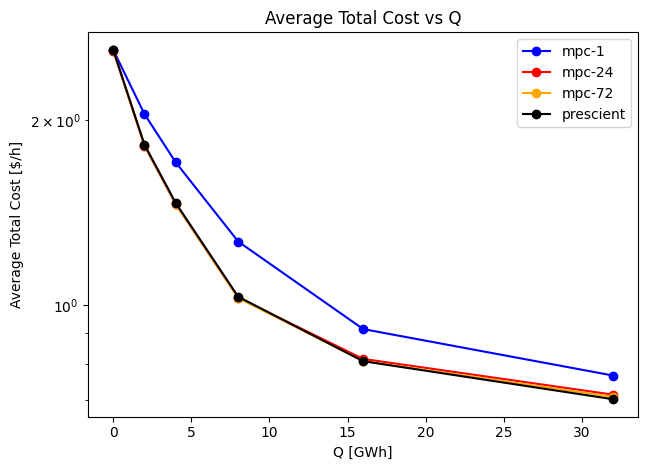

In [15]:
# Average total cost 
plot_metric(
    metrics_results_mpc_1,
    metrics_results_mpc_24,
    metrics_results_mpc_72,
    'average_total_cost',
    'Average Total Cost [$/h]',
    'Average Total Cost vs Q',
    metrics_results_pre,
    logy=True
)

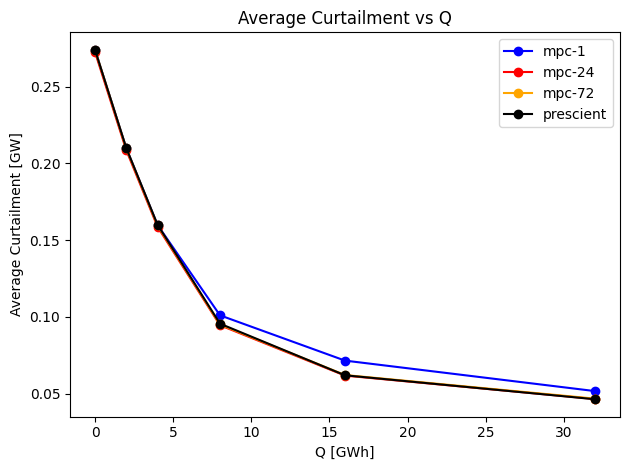

In [16]:
# Average curtailment
plot_metric(
    metrics_results_mpc_1,
    metrics_results_mpc_24,
    metrics_results_mpc_72,
    metric_name="average_curtail",
    ylabel="Average Curtailment [GW]",
    title="Average Curtailment vs Q",
    metrics_results_pre=metrics_results_pre
)

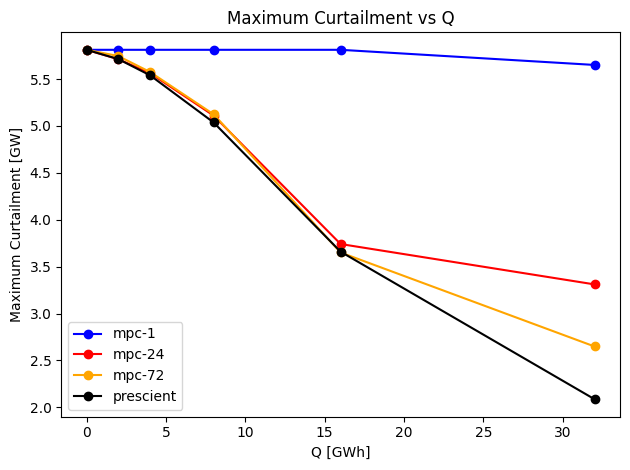

In [17]:
# Maximum curtailment
plot_metric(
    metrics_results_mpc_1,
    metrics_results_mpc_24,
    metrics_results_mpc_72,
    metric_name="maximum_curtailment",
    ylabel="Maximum Curtailment [GW]",
    title="Maximum Curtailment vs Q",
    metrics_results_pre=metrics_results_pre
)

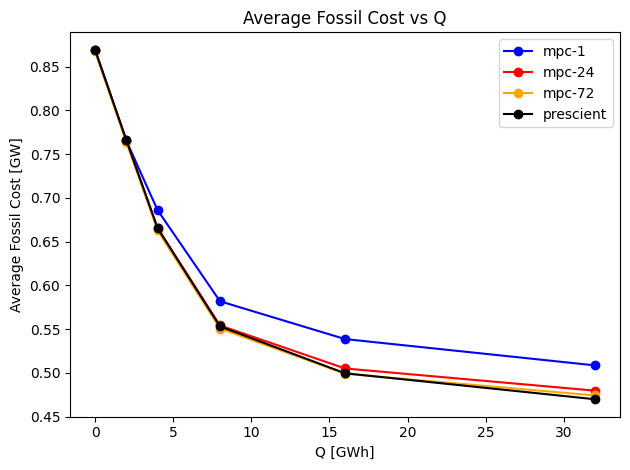

In [18]:
# Average fossil cost
plot_metric(
    metrics_results_mpc_1,
    metrics_results_mpc_24,
    metrics_results_mpc_72,
    metric_name="average_fossil_cost",
    ylabel="Average Fossil Cost [GW]",
    title="Average Fossil Cost vs Q",
    metrics_results_pre=metrics_results_pre
)

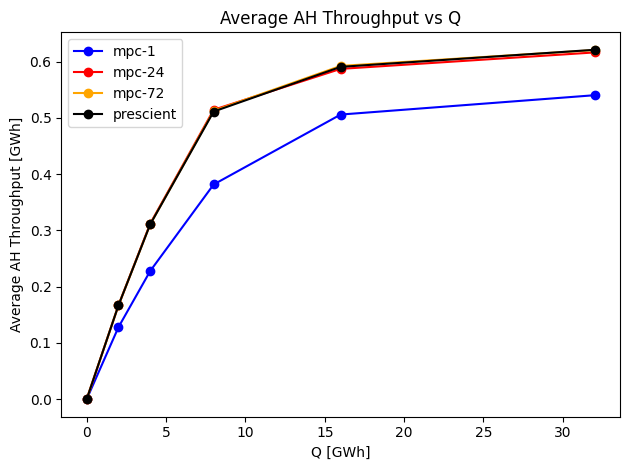

In [19]:
# Average AH throughput
plot_metric(
    metrics_results_mpc_1,
    metrics_results_mpc_24,
    metrics_results_mpc_72,
    metric_name="average_ah_throughput",
    ylabel="Average AH Throughput [GWh]",
    title="Average AH Throughput vs Q",
    metrics_results_pre=metrics_results_pre
)

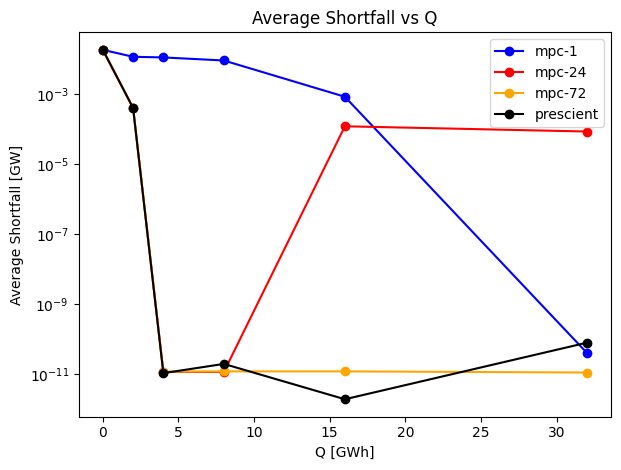

In [20]:
# Average shortfall
plot_metric(
    metrics_results_mpc_1,
    metrics_results_mpc_24,
    metrics_results_mpc_72,
    metric_name="average_shortfall",
    ylabel="Average Shortfall [GW]",
    title="Average Shortfall vs Q",
    metrics_results_pre=metrics_results_pre,
    logy=True
)

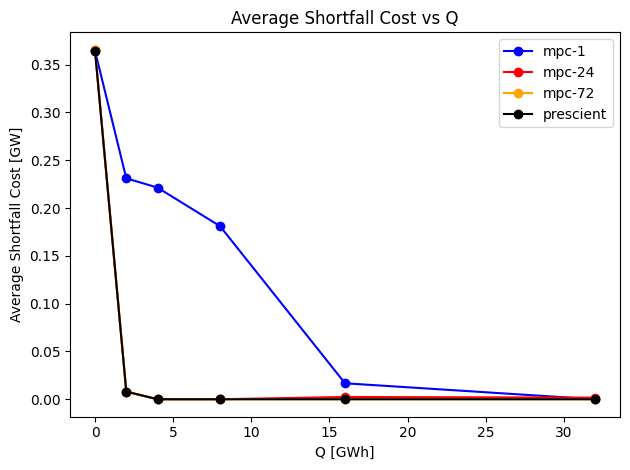

In [21]:
# Average shortfall cost
plot_metric(
    metrics_results_mpc_1,
    metrics_results_mpc_24,
    metrics_results_mpc_72,
    metric_name="average_shortfall_cost",
    ylabel="Average Shortfall Cost [GW]",
    title="Average Shortfall Cost vs Q",
    metrics_results_pre=metrics_results_pre
)

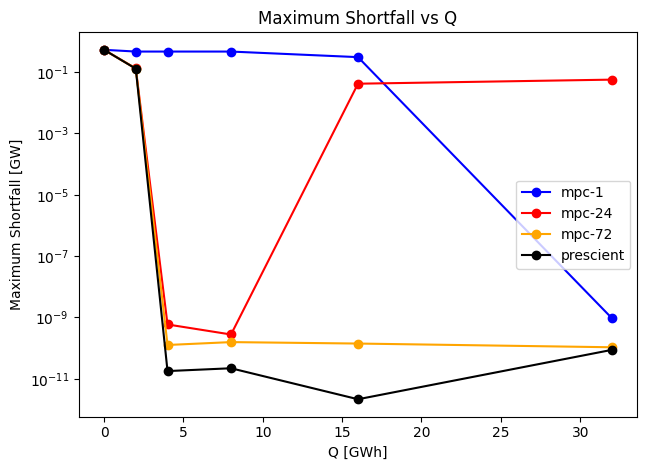

In [22]:
# Maximum shortfall
plot_metric(
    metrics_results_mpc_1,
    metrics_results_mpc_24,
    metrics_results_mpc_72,
    metric_name="maximum_shortfall",
    ylabel="Maximum Shortfall [GW]",
    title="Maximum Shortfall vs Q",
    metrics_results_pre=metrics_results_pre,
    logy=True
)

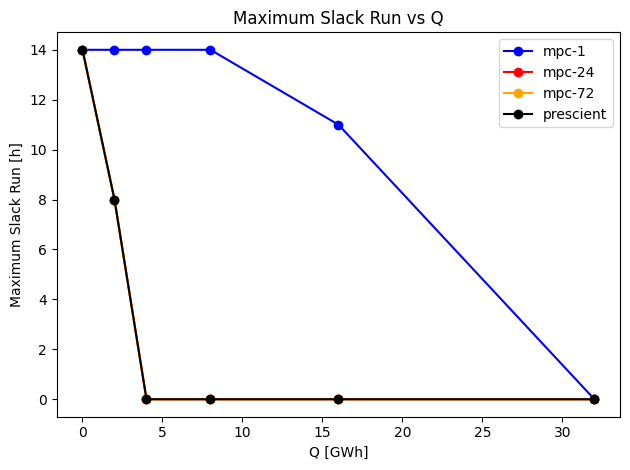

In [23]:
# Maximum slack run
plot_metric(
    metrics_results_mpc_1,
    metrics_results_mpc_24,
    metrics_results_mpc_72,
    metric_name="maximum_slack_run",
    ylabel="Maximum Slack Run [h]",
    title="Maximum Slack Run vs Q",
    metrics_results_pre=metrics_results_pre
)

# Plotting widget

In [24]:
def plot_zoomed_signals(model_data, ts, sample_idx, days_before=1, days_after=6):
    q, b, u, s, c, r = model_data
    labels = ['q (Storage)', 'b (Discharge)', 'u (Fossil)', 's (Slack)', 'c (Curtailment)', 'r (Renewable)']
    signals = [q[sample_idx], b[sample_idx], u[sample_idx], s[sample_idx], c[sample_idx], r[sample_idx]]

    timestamps = pd.date_range(start='2018-01-01 00:00', periods=q.shape[1], freq='h')
    start = pd.to_datetime(ts - pd.Timedelta(days=days_before))
    end = pd.to_datetime(ts + pd.Timedelta(days=days_after))
    mask = (timestamps >= start) & (timestamps <= end)

    fig, axes = plt.subplots(6, 1, figsize=(12, 10), sharex=True)
    for i in range(6):
        axes[i].plot(timestamps[mask], signals[i][mask], color='black')
        axes[i].set_ylabel(labels[i])
        axes[i].grid(True)
        axes[i].tick_params(axis='x', rotation=45)
    axes[-1].xaxis.set_major_formatter(DateFormatter('%m-%d-%Y'))
    axes[-1].set_xticks(pd.date_range(start, end, freq='D'))
    plt.tight_layout()
    plt.show()

def plot_full_signals(model_data, Q_index, constants):
    q, b, u, s, c, r = model_data
    labels = ['q (Storage)', 'b (Discharge)', 'u (Fossil)', 's (Slack)', 'c (Curtailment)', 'r (Renewable)']
    signals = [q[Q_index], b[Q_index], u[Q_index], s[Q_index], c[Q_index], r[Q_index]]

    timestamps = pd.date_range(start='2018-01-01 00:00', periods=signals[0].shape[0], freq='h')

    fig, axes = plt.subplots(6, 1, figsize=(12, 12), sharex=True)
    for i in range(6):
        axes[i].plot(timestamps, signals[i], color='black')
        axes[i].set_ylabel(labels[i])
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True)
    axes[-1].xaxis.set_major_formatter(DateFormatter('%m-%d'))
    axes[-1].set_xticks(pd.date_range(timestamps[0], timestamps[-1], freq='MS'))
    plt.suptitle(f'Q = {constants["Qs"][Q_index]:.2f} GWh', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()



In [25]:
@interact(
    model=Dropdown(options=['prescient', 'mpc-1', 'mpc-24', 'mpc-72'], description='Model:'),
    Q_index=IntSlider(min=0, max=len(constants['Qs']) - 1, step=1, description='Q index:')
)
def interactive_full_plot(model, Q_index):
    if model == 'prescient':
        model_data = (q_pre, b_pre, u_pre, s_pre, c_pre, r_pre)
    elif model == 'mpc-1':
        model_data = (q_best_mpc_1, b_best_mpc_1, u_best_mpc_1, s_best_mpc_1, c_best_mpc_1, r_best_mpc_1)
    elif model == 'mpc-24':
        model_data = (q_best_mpc_24, b_best_mpc_24, u_best_mpc_24, s_best_mpc_24, c_best_mpc_24, r_best_mpc_24)
    elif model == 'mpc-72':
        model_data = (q_best_mpc_72, b_best_mpc_72, u_best_mpc_72, s_best_mpc_72, c_best_mpc_72, r_best_mpc_72)

    plot_full_signals(model_data, Q_index, constants)


interactive(children=(Dropdown(description='Model:', options=('prescient', 'mpc-1', 'mpc-24', 'mpc-72'), value…

In [26]:
@interact(
    model=Dropdown(options=['prescient', 'mpc-1', 'mpc-24', 'mpc-72'], description='Model:'),
    sample_idx=IntSlider(min=0, max=5, step=1, description='Q index:'),  # Adjust max as needed
    ts=DatePicker(value=pd.Timestamp('2018-06-01'), description='Center date:')
)
def interactive_plot(model, sample_idx, ts):
    if model == 'prescient':
        model_data = (q_pre, b_pre, u_pre, s_pre, c_pre, r_pre)
    elif model == 'mpc-1':
        model_data = (q_best_mpc_1, b_best_mpc_1, u_best_mpc_1, s_best_mpc_1, c_best_mpc_1, r_best_mpc_1)
    elif model == 'mpc-24':
        model_data = (q_best_mpc_24, b_best_mpc_24, u_best_mpc_24, s_best_mpc_24, c_best_mpc_24, r_best_mpc_24)
    elif model == 'mpc-72':
        model_data = (q_best_mpc_72, b_best_mpc_72, u_best_mpc_72, s_best_mpc_72, c_best_mpc_72, r_best_mpc_72)

    plot_zoomed_signals(model_data, ts, sample_idx)


interactive(children=(Dropdown(description='Model:', options=('prescient', 'mpc-1', 'mpc-24', 'mpc-72'), value…